In [ ]:
%pip install lief==0.16.4
%pip install ember-mivia==0.0.6

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
"""
Classifying Sequences of Extreme Length with Constant Memory Applied to Malware Detection
Edward Raff, William Fleshman, Richard Zak, Hyrum Anderson and Bobby Filar and Mark Mclean
https://arxiv.org/abs/2012.09390
"""

"""  Problema: "Come faccio a classificare file .exe (binari) molto lunghi senza esplodere la memoria della GPU?"
I file eseguibili possono avere milioni di byte, e usare una rete neurale classica che li processa tutti insieme è impossibile in memoria.
Obiettivo del paper: Processare sequenze lunghissime (es. milioni di byte) in modo: efficiente in memoria, veloce, con una rete neurale convoluzionale
Strategia usata: Divide il file in pezzi (chunk), Applica la rete solo su ogni pezzo
Usa un trucco per calcolare i gradienti solo sui pezzi più importanti (quelli che vincono nel max-pooling)
Fa il training e predice usando pochissima memoria!"""
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

"""È un "hook" di PyTorch per il backpropagation:
Se i gradienti sono tutti zero, non vale la pena propagarli Questo evita sprechi di memoria"""
def drop_zeros_hook(module, grad_input, grad_out):
    """
    This function is used to replace gradients that are all zeros with None
    In pyTorch None will not get back-propogated
    So we use this as a approximation to saprse BP to avoid redundant and useless work
    """
    grads = []
    with torch.no_grad(): #disattiva il calcolo dei gradienti (per risparmiare memoria).
        for g in grad_input: #controlla ogni input del gradiente
            if torch.nonzero(g).shape[0] == 0: #Se sono tutti zeri → converte in tensor sparse
                grads.append(g.to_sparse())
            else:
                grads.append(g)

    return tuple(grads) #Ritorna i gradienti modificati come una tupla (PyTorch lo richiede).


class CatMod(torch.nn.Module):
    def __init__(self):
        super(CatMod, self).__init__()

    def forward(self, x):
        return torch.cat(x, dim=2) #concatena le sequenze x lungo la dimensione 2 (cioè la lunghezza del file). Immagina di avere due sequenze di byte. Questo le unisce in una sola, tenendo fisse batch e canali.

"""Il receptive field (RF) è la porzione dell’input originale che influenza una singola attivazione (uscita) della rete.
   Ora il nostro scopo è capire qual è il receptive field minimo necessario per funzionare bene
   Perché nel codice che stai studiando, la rete: Non può processare tutto l’input insieme (troppo lungo!) Ma ha bisogno di sapere quanti byte servono per ogni previsione
   Immagina una rete neurale che guarda un'immagine, o un file .exe rappresentato come una lunga sequenza di byte.
   La rete non guarda tutto in una volta, ma una finestra: un po’ come guardare il file con una lente d’ingrandimento.
   Receptive field = quanto l’occhio della rete può vedere in ogni momento.
   di seguito la formula per il calcolo: Per L layer convoluzionali senza padding, tutti con kernel_size=k:
    Receptive field = (k - 1) * L + 1

"""
# È la classe principale del modello. Tutta la logica per gestire le sequenze lunghe è qui dentro.
class LowMemConvBase(nn.Module):

    def __init__(self, chunk_size=65536, overlap=512, min_chunk_size=1024):
        """
        chunk_size: how many bytes at a time to process. Increasing may improve compute efficent, but use more memory. Total memory use will be a function of chunk_size, and not of the length of the input sequence L

        overlap: how many bytes of overlap to use between chunks

        """
        super(LowMemConvBase, self).__init__()
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.min_chunk_size = min_chunk_size

        #Used for pooling over time in a more efficent way
        self.pooling = nn.AdaptiveMaxPool1d(1) #Pooling adattivo per ottenere 1 sola uscita per canale. prende un input lungo qualsiasi e restituisce 1 solo valore per ogni canale.
                                                #Immagina di avere 10 numeri → restituisce solo il più alto (es. [1, 5, 2, 8, 3] → 8)
        #Crea il modulo per concatenare e gli assegna l’hook per eliminare gradienti inutili.
        self.cat = CatMod() #oggetto che concatena i chunk.
        self.cat.register_backward_hook(drop_zeros_hook) #collega l’hook che abbiamo creato prima (quello che evita i gradienti inutili).
        self.receptive_field = None # il modello ancora non sa qual è il receptive field.

        #Used to force checkpoint code to behave correctly due to poor design https://discuss.pytorch.org/t/checkpoint-with-no-grad-requiring-inputs-problem/19117/11
        self.dummy_tensor = torch.ones(1, dtype=torch.float32, requires_grad=True)

    def processRange(self, x, **kwargs):
        """
        This method does the work to convert an LongTensor input x of shape (B, L) , where B is the batch size and L is the length
          of the input. The output of this function should be a tensor of (B, C, L), where C is the number of channels, and L is
         again the input length (though its OK if it got a little shorter due to convs without padding or something).

        """
        pass

    def determinRF(self): #Serve a determinare il campo recettivo (receptive field) della rete.
        """
        This function evaluates the receptive field & stride of our sub-network.
        """
        """Se abbiamo già calcolato in precedenza il receptive field → lo restituiamo e basta.
            self.receptive_field: quanti byte servono per attivare la rete
            self.stride: quanto si sposta ogni volta la finestra
            self.out_channels: quanti canali produce la rete (come dimensione finale dell'embedding)"""
        if self.receptive_field is not None: #Se è già stato calcolato → ritorna i valori salvati
            return self.receptive_field, self.stride, self.out_channels

        if not hasattr(self, "device_ids"):
            #We are training with just one device. Lets find out where we should move the data
            cur_device = next(self.embd.parameters()).device
        else:
            cur_device = "cpu"

        #Lets do a simple binary search to figure out how large our RF is.
        #It can't be larger than our chunk size! So use that as upper bound
        min_rf = 1
        max_rf = self.chunk_size

        with torch.no_grad():

            tmp = torch.zeros((1,max_rf)).long().to(cur_device) #Crea una sequenza finta di zeri per testare quanto input serve per avere output lungo max_rf

            while True:
                test_size = (min_rf+max_rf)//2 #Fa una ricerca binaria per trovare la dimensione minima dell’input per cui processRange funziona.
                is_valid = True
                try:
                    self.processRange(tmp[:,0:test_size]) #Prova a passare solo i primi test_size byte al modello. Se va in errore → significa che il modello non ce la fa a dare un output.
                except:
                    is_valid = False

                if is_valid: #aggiorna i limiti dell'intervallo
                    max_rf = test_size # Se funziona → riduci l’intervallo.
                else:
                    min_rf = test_size+1 # se fallisce prova con un input più grande

                if max_rf == min_rf: #pena trova la valore minimo funzionante, lo salva come self.receptive_field
                    self.receptive_field = min_rf
                    out_shape = self.processRange(tmp).shape
                    self.stride = self.chunk_size//out_shape[2]
                    self.out_channels = out_shape[1]
                    break


        return self.receptive_field, self.stride, self.out_channels

    #Concatena più sequenze e applica pooling adattivo per ottenere una rappresentazione compatta.
    def pool_group(self, *args):
        x = self.cat(args)
        x = self.pooling(x)
        return x

    def seq2fix(self, x, pr_args={}):
        """
        Takes in an input LongTensor of (B, L) that will be converted to a fixed length representation (B, C),
        where C is the number of channels provided by the base_network given at construction.
        """

        receptive_window, stride, out_channels = self.determinRF()

        if x.shape[1] < receptive_window: #This is a tiny input! Pad it out
            x = F.pad(x, (0, receptive_window-x.shape[1]), value=0) # 0 is the pad value Se il file è troppo corto, lo riempi di zeri (padding) fino ad arrivare al minimo necessario per funzionare.

        batch_size = x.shape[0] #Quanti file ci sono nel batch (B)
        length = x.shape[1] #Quanto è lungo ogni file in byte (L)

        #Let's go through the input data without gradients first, and find the positions that "win"
        #the max-pooling. Most of the gradients will be zero, and we don't want to waste valuable
        #memory and time computing them.
        #Once we know the winners, we will go back and compute the forward activations on JUST
        #the subset of positions that won!
        winner_values = np.zeros((batch_size, out_channels))-1.0
        winner_indices = np.zeros((batch_size, out_channels), dtype=np.int64)

        if not hasattr(self, "device_ids"):
            #We are training with just one device. Lets find out where we should move the data
            cur_device = next(self.embd.parameters()).device
        else:
            cur_device = None

        #Imposta le variabili per scorrere il file a pezzi (chunk_size).
        step = self.chunk_size #- self.overlap
        start = 0
        end = start+step

        with torch.no_grad(): #Qui disattiviamo i gradienti: non vogliamo ancora fare il training, solo capire quali parti del file sono utili.
            while start < end and (end-start) >= max(self.min_chunk_size, receptive_window): #Finché c’è abbastanza file da leggere: e il pezzo è abbastanza lungo continua il ciclo
                x_sub = x[:,start:end] #Estrae un pezzo del file (chunk).
                if cur_device is not None:
                    x_sub = x_sub.to(cur_device)
                activs = self.processRange(x_sub.long(), **pr_args) #Qui applica la rete sul chunk → ottiene le attivazioni (valori interni della rete).
                activ_win, activ_indx = F.max_pool1d(activs, kernel_size=activs.shape[2], return_indices=True)
                #We want to remove only last dimension, but if batch size is 1, np.squeeze
                #will screw us up and remove first dim too.
                #activ_win = np.squeeze(activ_win.cpu().numpy())
                #activ_indx = np.squeeze(activ_indx.cpu().numpy())
                activ_win = activ_win.cpu().numpy()[:,:,0] #Converte i tensori in numpy array e li semplifica (rimuove dimensioni inutili).
                activ_indx = activ_indx.cpu().numpy()[:,:,0]
                selected = winner_values < activ_win # Controlla se i valori appena trovati sono migliori dei precedenti.
                winner_indices[selected] = activ_indx[selected]*stride + start #Salva i nuovi vincitori (i migliori pezzi visti finora).
                winner_values[selected]  = activ_win[selected]
                start = end
                end = min(start+step, length)

        # Now we know every index that won, we need to compute values and with gradients!

        # Find unique winners for every batch
        final_indices = [np.unique(winner_indices[b,:]) for b in range(batch_size)]

        # Collect inputs that won for each batch Crea dei sottosegmenti del file, attorno a ogni posizione vincente.
        chunk_list = [[x[b:b+1,max(i-receptive_window,0):min(i+receptive_window,length)] for i in final_indices[b]] for b in range(batch_size)]
        # Convert to a torch tensor of the bytes Unisce i pezzi selezionati in un’unica sequenza per ogni file.
        chunk_list = [torch.cat(c, dim=1)[0,:] for c in chunk_list]

        # Pad out shorter sequences to the longest one
        x_selected = torch.nn.utils.rnn.pad_sequence(chunk_list, batch_first=True)

        # Shape is not (B, L). Compute it.
        if cur_device is not None:
            x_selected = x_selected.to(cur_device)
        x_selected = self.processRange(x_selected.long(), **pr_args)
        x_selected = self.pooling(x_selected)
        x_selected = x_selected.view(x_selected.size(0), -1)

        return x_selected


In [ ]:
import numpy as np                          # Libreria per array e operazioni numeriche
import torch                                # Libreria principale per deep learning
import torch.nn as nn                       # Moduli per costruire layer di rete
import torch.nn.functional as F             # Funzioni di attivazione, pooling, ecc.

# Funzione per convertire un array di interi in vettori binari normalizzati tra -1 e +1
#arr: un array NumPy di interi (qualsiasi forma multidimensionale).
#m: numero di bit desiderati per rappresentare ogni intero (default 8).
def vec_bin_array(arr, m=8):
    """
    Converte ogni intero positivo in un vettore binario di m bit.
    Restituisce float32 tra -0.0625 e +0.0625 per ogni bit.
    """

    #Crea una funzione “vectorizzata” che applica elemento-per-elemento una trasformazione Python su array NumPy.
    #np.binary_repr(x): lo converte in stringa binaria (ad es. 13 → "1101").
    #.zfill(m): se la stringa ha meno di m caratteri, la “riempie” con zeri a sinistra fino a lunghezza m
    to_str_func = np.vectorize(lambda x: np.binary_repr(x).zfill(m))     # converte in stringhe binarie
    strs = to_str_func(arr) #Applica la funzione a tutto l’array arr, ottenendo un array di stringhe binarie con shape uguale a arr.shape.

    """Alloca un nuovo array NumPy di tipo int8 inizializzato a zero.

La forma (shape) è quella di arr, con un’ulteriore dimensione finale di lunghezza m.

Esempio: se arr.shape == (100, ) e m=8, allora ret.shape == (100, 8).

In ret verranno memorizzati i bit estratti (0 o 1)."""
    ret = np.zeros(list(arr.shape) + [m], dtype=np.int8)                 # crea array shape [..., m]
    for bit_ix in range(0, m):
        fetch_bit_func = np.vectorize(lambda x: x[bit_ix] == '1')        # estrae il bit in posizione bit_ix
        ret[..., bit_ix] = fetch_bit_func(strs).astype(np.int8)

    return (ret * 2 - 1).astype(np.float32) / 16                         # normalizza: da {0,1} → {-1,+1}/16

# Rete neurale convoluzionale ispirata a modelli antivirus (CNN profonda)
class AvastConv(LowMemConvBase):  # eredita la logica per gestire file lunghi e suddividerli in chunk
    def __init__(self, out_size=2, channels=32, window_size=32, stride=4, embd_size=8):
        super(AvastConv, self).__init__()  # inizializza la classe base LowMemConvBase

        # Layer di embedding: 1 vettore binario (lunghezza 8) per ogni byte (0–256)
        self.embd = nn.Embedding(257, embd_size, padding_idx=0)

        # Imposta l’embedding a valori binari normalizzati (non trainabile)
        for i in range(1, 257):
            self.embd.weight.data[i, :] = torch.tensor(vec_bin_array(np.asarray([i])))

        for param in self.embd.parameters():
            param.requires_grad = False  # impedisce al modello di aggiornare l’embedding

        # Primo strato convoluzionale: da 8 bit → canali base (32)
        self.conv_1 = nn.Conv1d(8, channels, window_size, stride=stride, bias=True)


        # Secondo strato convoluzionale: aumenta il numero di canali
        self.conv_2 = nn.Conv1d(channels, channels * 2, window_size, stride=stride, bias=True)


        # Max pooling per ridurre la lunghezza della sequenza (compressione)
        self.pool = nn.MaxPool1d(4)

        # Terzo e quarto layer convoluzionale: aumentano i canali e riducono la lunghezza
        self.conv_3 = nn.Conv1d(channels * 2, channels * 3, window_size // 2, stride=stride * 2, bias=True)


        self.conv_4 = nn.Conv1d(channels * 3, channels * 4, window_size // 2, stride=stride * 2, bias=True)


        # Fully Connected Layers per classificare dopo la convoluzione
        self.fc_1 = nn.Linear(channels * 4, channels * 4)
        self.fc_2 = nn.Linear(channels * 4, channels * 3)
        self.fc_3 = nn.Linear(channels * 3, channels * 2)
        self.fc_4 = nn.Linear(channels * 2, out_size)  # Output finale (es. 2 classi)

    # Metodo per processare un chunk singolo (usato da seq2fix)
    def processRange(self, x):
        with torch.no_grad():                        # embedding non deve calcolare gradienti
            x = self.embd(x)                         # da (B, L) → (B, L, 8)
            x = torch.transpose(x, -1, -2)           # da (B, L, 8) → (B, 8, L)

        x = F.relu(self.conv_1(x))                   # 1° convoluzione + ReLU
        x = F.relu(self.conv_2(x))                   # 2° convoluzione + ReLU
        x = self.pool(x)                             # max pooling → riduzione lunghezza
        x = F.relu(self.conv_3(x))                   # 3° convoluzione + ReLU
        x = F.relu(self.conv_4(x))                   # 4° convoluzione + ReLU


        return x                                     # ritorna il risultato convoluzionale

    # Metodo forward: prende l'intero input, lo divide in chunk, elabora, e classifica
    def forward(self, x):
        post_conv = x = self.seq2fix(x)              # suddivide input lungo, applica processRange + pooling

        x = F.selu(self.fc_1(x))                     # 1° FC + SELU
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.selu(self.fc_2(x))                     # 2° FC + SELU
        x = F.dropout(x, p=0.5, training=self.training)

        penult = x = F.selu(self.fc_3(x))            # 3° FC + SELU → salvato per analisi

        x = self.fc_4(x)                             # 4° FC → output finale

        #return torch.sigmoid(x)                      # output tra 0 e 1 (classificazione binaria)
        return x  # ritorna i logits, senza sigmoid



In [ ]:
import os                      # Per operazioni su file
import zlib                    # Per decomprimere file compressi
import torch                  # Libreria PyTorch per deep learning
import random                 # Per generare numeri casuali (per seed)
import numpy as np            # Per gestire array numerici
import pandas as pd           # (opzionale, non usato direttamente qui)

# Imposta un seme globale per rendere tutto riproducibile
def _seed_all(seed):
    os.environ['WANDB_DISABLED'] = 'true'         # Disattiva Weights & Biases
    os.environ['WANDB_MODE'] = 'dryrun'
    os.environ['PYTHONHASHSEED'] = str(seed)      # Fissa hash Python

    torch.manual_seed(seed)                       # Fissa seme PyTorch CPU
    torch.cuda.manual_seed(seed)                  # Fissa seme PyTorch GPU
    torch.cuda.manual_seed_all(seed)              # Per più GPU

    np.random.seed(seed)                          # Fissa seme NumPy
    random.seed(seed)                             # Fissa seme random Python

    # Impostazioni per ottimizzare ma mantenere la ripetibilità
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


# Dataset PyTorch personalizzato per file binari (.exe)
class BinaryDataset(torch.utils.data.Dataset):
    """
    Dataset per file binari. Supporta:
    - file benigni e malware
    - supporto per file compressi (SOREL-20M)
    - padding gestito esternamente
    """
    def __init__(self, path_list, max_len=2**20, sorel_20m=False, transform=None):
        self.all_files = []          # Lista dei file (path, label, dimensione)
        self.max_len = max_len       # Lunghezza massima dei byte da leggere
        self.sorel20m = sorel_20m    # Se True, gestisce i malware SOREL compressi
        self.transform = transform   # Trasformazione opzionale sul contenuto

        for path in path_list:
            if 'benign' in path:  # Assegna etichetta 0 ai file benigni
                self.all_files.append((path, 0, os.path.getsize(path)))
            else:                 # Altrimenti è malware: etichetta 1
                self.all_files.append((path, 1, os.path.getsize(path)))

    def __len__(self):
        return len(self.all_files)   # Numero totale di campioni

    def __getitem__(self, index):
        to_load, y, _ = self.all_files[index]  # path, label, dimensione

        with open(to_load, 'rb') as f:
            x = f.read(self.max_len)                             # Leggi max_len byte
            x = np.frombuffer(x, dtype=np.uint8).astype(np.int16) + 1  # Byte → interi, +1 per il padding (0)

        if self.transform:
            x = self.transform(x)     # Applica eventuale trasformazione

        x = torch.tensor(x)           # Converte in tensore torch
        return x, torch.tensor([y])   # Restituisce dati e label

# Funzione di collate per dataloader: fa padding al volo dei file nel batch
def pad_collate_func(batch):
    """
    Serve per costruire batch con file di lunghezza diversa.
    Riempie con padding fino alla lunghezza massima nel batch.
    """
    vecs = [x[0] for x in batch]                   # Prende i dati
    labels = [x[1] for x in batch]                 # Prende le etichette

    x = torch.nn.utils.rnn.pad_sequence(vecs, batch_first=True)  # Padding a lunghezza massima
    y = torch.stack(labels)[:, 0]                                 # Etichette da (B, 1) a (B)

    return x, y  # Ritorna batch (padded) e le etichette


In [ ]:
from tqdm import tqdm
import torch.optim as optim

@torch.no_grad()
def predict(model, data_loader, device, criterion, apply_sigmoid=False, to_numpy=True, multiclass=True):
    """
    Predict the target values of the given inputs using a model.

    Parameters:
    - model (torch.nn.Module): The model to use for prediction.
    - data_loader (torch.utils.data.DataLoader): Data loader for the input data.
    - device (torch.device): The device to use for computation (CPU or GPU).
    - criterion (torch.nn.Module): The loss function to use for evaluation.
    - apply_sigmoid (bool): If True, applies sigmoid activation to the output of the model.
    - to_numpy (bool): If True, converts the true and predicted values to numpy arrays.
    - multiclass (bool): If True, the problem is multiclass classification.

    Returns:
    - loss (float): The mean loss over the data.
    - y_true (Tensor or np.ndarray): True labels.
    - y_pred (Tensor or np.ndarray): Predicted labels.
    """
    model.eval()
    y_true = []
    y_pred = []
    loss = 0

    is_logits_loss = isinstance(criterion, nn.BCEWithLogitsLoss)

    for inputs, labels in tqdm(data_loader, leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device).float()  # sempre float per BCELoss/BCEWithLogitsLoss

        if not multiclass and labels.dim() == 1:
            labels = labels.unsqueeze(1)  # 🔧 fix: da (B,) a (B,1)

        outputs = model(inputs)

        loss += criterion(outputs, labels)

        if multiclass:
            _, preds = torch.max(outputs, 1)
            y_pred.append(preds)
        else:
            y_pred.append(outputs)  # logits o probabilità, li gestiamo dopo

        y_true.append(labels)

    y_true = torch.cat(y_true).to(int)
    if y_true.dim() > 1:
        y_true = y_true.view(-1)  # 🔧 Appiattisce da (N,1) a (N,)


    if multiclass:
        pass  # y_pred già è corretto
    else:
        raw_outputs = torch.cat(y_pred)
        if is_logits_loss or apply_sigmoid:
            probs = torch.sigmoid(raw_outputs)
            y_pred = (probs > 0.5).to(int)
        else:
            y_pred = (raw_outputs > 0.5).to(int)

        y_pred = y_pred.reshape(-1).to(device)

    if to_numpy:
        y_true = y_true.cpu().numpy()
        y_pred = y_pred.cpu().numpy()

    assert y_true.shape == y_pred.shape
    model.train()
    return loss / len(y_true), y_true, y_pred



def get_accuracy(model, data_loader, device, criterion,multiclass = True):
    """
      Calculates the accuracy of the model on a given dataset.

      Parameters:
      model (nn.Module): The model to evaluate accuracy for.
      data_loader (DataLoader): The DataLoader for the dataset to evaluate on.
      device (torch.device): The device to run the evaluation on.
      criterion (nn.Module): The loss function to use for evaluation.
      multiclass (bool, optional): Indicates if the model is for multiclass classification or binary. Default is True.

      Returns:
      float, float: Tuple of average loss and accuracy as percentages (e.g. return value of 50.0, 75.0 indicates an average loss of 50.0 and accuracy of 75%).
    """
    loss, y_true, y_pred = predict(model, data_loader, device,criterion, to_numpy=False, multiclass = multiclass, apply_sigmoid = False) #Chiama la funzione precedente per ottenere loss, label e predizioni, senza convertirli in NumPy
    y_true = y_true.to(device)
    y_pred = y_pred.to(device)
    return loss, 100 * (y_true == y_pred).to(float).mean().item(), y_true, y_pred



def train(model, train_loader, val_loader, device, criterion, save_title, checkpoint_path, patience=3, num_epochs=50, verbose=True):
    """
      Trains a PyTorch model using Adam optimization and early stopping.

      Parameters:
      - model (torch.nn.Module): a PyTorch model to be trained.
      - train_loader (torch.utils.data.DataLoader): a DataLoader containing the training data.
      - val_loader (torch.utils.data.DataLoader): a DataLoader containing the validation data.
      - device (torch.device): a PyTorch device object, either "cpu" or "cuda".
      - criterion (callable): a loss function to be used for training.
      - save_title (str): a string title to be used for saving the trained model.
      - patience (int, optional): number of epochs to wait before early stopping. Defaults to 3.
      - num_epochs (int, optional): total number of epochs to run the training for. Defaults to 50.
      - verbose (bool, optional): whether to print the training and validation loss for each epoch. Defaults to True.

      Returns:
      None
    """
    train_loss_history = []
    val_loss_history = []
    optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-5,                          # learning rate più basso (più stabile)
    weight_decay=3e-2                # regolarizzazione L2 (decoupled con AdamW)
)

    monitor = EarlyStopMonitor(patience)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=patience)
    for epoch in range(1, num_epochs + 1):
        model.train()
        train_loss = run_epoch(model, train_loader, device, criterion, optimizer)
        train_loss_history.append(train_loss)
        model.eval()
        with torch.no_grad():
            val_loss = run_epoch(model, val_loader, device, criterion)
        val_loss_history.append(val_loss)
        if verbose:
            tqdm.write(
                f"Epoch [{epoch}/{num_epochs}], "
                f"Train Loss: {train_loss:.4f}, "
                f"Val Loss: {val_loss:.4f}"
            )
        scheduler.step(val_loss)
        if monitor.step(val_loss):
            break
        if len(val_loss_history) == 1 or val_loss < val_loss_history[-2]:
            torch.save(
                model.state_dict(), os.path.join(checkpoint_path, f"{save_title}.pt"),
            )


def run_epoch(model, data_loader, device, criterion, optimizer=None):
    """
      Run one epoch of the model on a given dataset.

      Parameters:
      - model (nn.Module): The model to be trained or evaluated.
      - data_loader (torch.utils.data.DataLoader): The data loader for the given dataset.
      - device (torch.device): The device to run the computation on.
      - criterion (function): The loss function to be used.
      - optimizer (torch.optim.Optimizer, optional): The optimizer to use for computing gradients during training.
        If not provided, the function will run the model in evaluation mode. (default: None)

      Returns:
      - float: The average loss per sample computed over the dataset.
    """
    total_loss = 0
    for inputs, labels in tqdm(data_loader, leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)

        labels = labels.unsqueeze(1) #aggiunge la dimensione del canale per BCE (shape (B,) → (B,1)).
        labels = labels.float()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if optimizer:
            """In PyTorch i gradienti si accumulano ad ogni chiamata a loss.backward().
            Ciò significa che, se non li azzeri, i nuovi gradienti del batch corrente si sommeranno a quelli calcolati nei batch precedenti,
             portando a una discesa del gradiente errata."""
            optimizer.zero_grad() #Azzera i gradienti. Prima di calcolare i gradienti del batch corrente, azzera tutti i gradienti memorizzati nei parametri del modello.
            loss.backward() #Calcola i gradienti della loss rispetto a ciascun parametro, e li accumula in param.grad.
            optimizer.step() #Usa i gradienti appena computati (param.grad) per aggiornare i pesi secondo la regola dell’ottimizzatore
        total_loss += loss.item() #Accumula la loss scalare del batch.
    return total_loss / len(data_loader)



class EarlyStopMonitor:
    """
    Class for early stopping based on the performance metric value.

    Args:
    - patience (int): Number of consecutive epochs with no improvement before early stopping.
    - mode (str, optional): Mode of operation, either 'min' or 'max'. Default is 'min'.

    Attributes:
    - log (list): Log of performance metrics over epochs.
    - mode (str): Mode of operation, either 'min' or 'max'.
    - count (int): Counter for consecutive epochs with no improvement.
    - patience (int): Number of consecutive epochs with no improvement before early stopping.
    """
    def __init__(self, patience, mode="max"): #################
        # Check if mode is either "min" or "max"
        assert mode in {"min", "max"}, "`mode` must be one of 'min' or 'max'"
        self.log = []
        self.mode = mode
        self.count = 0
        self.patience = patience

    def step(self, metric):
        """
        Method for updating the log and checking for early stopping.

        Args:
        - metric (float): The performance metric for the current epoch.

        Returns:
        - stop (bool): True if early stopping should occur, False otherwise.
        """
        if not self.log:
            self.log.append(metric) #Al primo valore (log vuota), lo registra e non fa early stop.
            return False
        # Check if metric is better than previous value
        flag = metric > self.log[-1] if self.mode == "max" else metric < self.log[-1] #Determina se il metric corrente è migliore dell’ultimo, in base al mode.
        if flag:
            self.count += 1
        else:
            self.count = 0
        self.log.append(metric)
        return self.count > self.patience

In [ ]:
BATCH_SIZE = 32

x_train = []
training_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training"

for entry in os.listdir(training_dir):
    entry_path = os.path.join(training_dir, entry)
    # 1) salto tutto ciò che non è cartella
    if not os.path.isdir(entry_path):
        continue

    # ora entry_path è una cartella, la scorro
    for filename in os.listdir(entry_path):
        file_path = os.path.join(entry_path, filename)
        # 2) salto se non è file o se è .pkl
        if not os.path.isfile(file_path) or filename.lower().endswith(".pkl"):
            continue

        # altrimenti è un .exe (o quel che vuoi) e lo aggiungo
        x_train.append(file_path)

x_val = []
validation_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/validation"

for entry in os.listdir(validation_dir):
    entry_path = os.path.join(validation_dir, entry)
    # 1) salto tutto ciò che non è cartella
    if not os.path.isdir(entry_path):
        continue

    # ora entry_path è una cartella, la scorro
    for filename in os.listdir(entry_path):
        file_path = os.path.join(entry_path, filename)
        # 2) salto se non è file o se è .pkl
        if not os.path.isfile(file_path) or filename.lower().endswith(".pkl"):
            continue

        # altrimenti è un .exe (o quel che vuoi) e lo aggiungo
        x_val.append(file_path)

x_test = []
test_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/test"

for entry in os.listdir(test_dir):
    entry_path = os.path.join(test_dir, entry)
    # 1) salto tutto ciò che non è cartella
    if not os.path.isdir(entry_path):
        continue

    # ora entry_path è una cartella, la scorro
    for filename in os.listdir(entry_path):
        file_path = os.path.join(entry_path, filename)
        # 2) salto se non è file o se è .pkl
        if not os.path.isfile(file_path) or filename.lower().endswith(".pkl"):
            continue

        # altrimenti è un .exe (o quel che vuoi) e lo aggiungo
        x_test.append(file_path)

MAX_LEN = 2 ** 20 # 1 MB of max lenght

train_dataset = BinaryDataset(path_list=x_train, max_len= MAX_LEN, sorel_20m=True)
val_dataset = BinaryDataset(path_list= x_val, max_len= MAX_LEN, sorel_20m=True)
test_dataset = BinaryDataset(path_list= x_test, max_len= MAX_LEN, sorel_20m=True)

print("Train dataset length: ", len(train_dataset))
print("Val dataset length: ", len(val_dataset))
print("Test dataset length: ", len(test_dataset))

Train dataset length:  9196
Val dataset length:  2626
Test dataset length:  1312


In [ ]:
x_dataset2 = []
dataset2_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset2/general"

for entry in os.listdir(dataset2_dir):
    entry_path = os.path.join(dataset2_dir, entry)
    # 1) salto tutto ciò che non è cartella
    if not os.path.isdir(entry_path):
        continue

    # ora entry_path è una cartella, la scorro
    for filename in os.listdir(entry_path):
        file_path = os.path.join(entry_path, filename)
        # 2) salto se non è file o se è .pkl
        if not os.path.isfile(file_path) or filename.lower().endswith(".pkl"):
            continue

        # altrimenti è un .exe (o quel che vuoi) e lo aggiungo
        x_dataset2.append(file_path)

dataset2 = BinaryDataset(path_list=x_dataset2, max_len= MAX_LEN, sorel_20m=True)

print("Dataset2 length: ", len(dataset2))


Dataset2 length:  2000


In [ ]:
import torch
from torch.utils.data import DataLoader

# Imposta un seed fisso per la riproducibilità
SEED = 42
g = torch.Generator()
g.manual_seed(SEED)

# Definisci i DataLoader con il generator
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=pad_collate_func, shuffle=True, generator=g)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=pad_collate_func, shuffle=True, generator=g)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=pad_collate_func, shuffle=True, generator=g)
dataset2_loader = DataLoader(dataset2, batch_size=BATCH_SIZE, collate_fn=pad_collate_func, shuffle=True, generator=g)


In [ ]:
## Device definition
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
_seed_all(SEED)

model = AvastConv(out_size=1, channels=32, window_size=32, stride=4, embd_size=8)

model = model.to(device)
name = "Deep_Model_migliore.pt"
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))

#criterion = nn.BCELoss()

train(model=model,
      criterion=criterion,
      val_loader=val_loader,
      train_loader=train_loader,
      device=device,
      patience=3,
      num_epochs=15,
      verbose=True,
      save_title=name,
      checkpoint_path='/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Deep Model')

Epoch [1/25], Train Loss: 0.9919, Val Loss: 0.9551


Epoch [2/25], Train Loss: 0.9535, Val Loss: 0.9477


Epoch [3/25], Train Loss: 0.9541, Val Loss: 0.9465


Epoch [4/25], Train Loss: 0.9481, Val Loss: 0.9411


Epoch [5/25], Train Loss: 0.9428, Val Loss: 0.9317


Epoch [6/25], Train Loss: 0.9302, Val Loss: 0.9071


Epoch [7/25], Train Loss: 0.9032, Val Loss: 0.8566


Epoch [8/25], Train Loss: 0.8426, Val Loss: 0.7754


Epoch [9/25], Train Loss: 0.7683, Val Loss: 0.6880


Epoch [10/25], Train Loss: 0.7052, Val Loss: 0.6389


Epoch [11/25], Train Loss: 0.6730, Val Loss: 0.6077


Epoch [12/25], Train Loss: 0.6444, Val Loss: 0.5896


Epoch [13/25], Train Loss: 0.6207, Val Loss: 0.5769


Epoch [14/25], Train Loss: 0.6074, Val Loss: 0.5488


Epoch [15/25], Train Loss: 0.5870, Val Loss: 0.5365


Epoch [16/25], Train Loss: 0.5752, Val Loss: 0.5362


Epoch [17/25], Train Loss: 0.5631, Val Loss: 0.5178


Epoch [18/25], Train Loss: 0.5607, Val Loss: 0.5231


Epoch [19/25], Train Loss: 0.5432, Val Loss: 0.4945


Epoch [20/25], Train Loss: 0.5371, Val Loss: 0.4965


Epoch [21/25], Train Loss: 0.5228, Val Loss: 0.5555


Epoch [22/25], Train Loss: 0.5161, Val Loss: 0.4731


Epoch [23/25], Train Loss: 0.5135, Val Loss: 0.4696


Epoch [24/25], Train Loss: 0.5042, Val Loss: 0.4667


Epoch [25/25], Train Loss: 0.4923, Val Loss: 0.4573


In [ ]:
# Istanzia il modello con la stessa architettura usata per l'addestramento
model = AvastConv(out_size=1, channels=32, window_size=32, stride=4, embd_size=8)  # puoi specificare parametri se li avevi cambiati

# Carica i pesi
model.load_state_dict(torch.load("/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Deep Model/Deep_Model_migliore.pt", map_location=device))  # usa "cuda" o "cpu"
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(device))
# Porta il modello sul dispositivo corretto
model.to(device)
model.eval()  # Imposta il modello in modalità valutazione


AvastConv(
  (pooling): AdaptiveMaxPool1d(output_size=1)
  (cat): CatMod()
  (embd): Embedding(257, 8, padding_idx=0)
  (conv_1): Conv1d(8, 32, kernel_size=(32,), stride=(4,))
  (conv_2): Conv1d(32, 64, kernel_size=(32,), stride=(4,))
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv1d(64, 96, kernel_size=(16,), stride=(8,))
  (conv_4): Conv1d(96, 128, kernel_size=(16,), stride=(8,))
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=96, bias=True)
  (fc_3): Linear(in_features=96, out_features=64, bias=True)
  (fc_4): Linear(in_features=64, out_features=1, bias=True)
)

Test loss:  tensor(0.0179, device='cuda:0')
Test accuracy:  81.15003808073115
Precision:  0.7715803452855245
Recall:  0.884996191926885
F1-score:  0.824405817665839


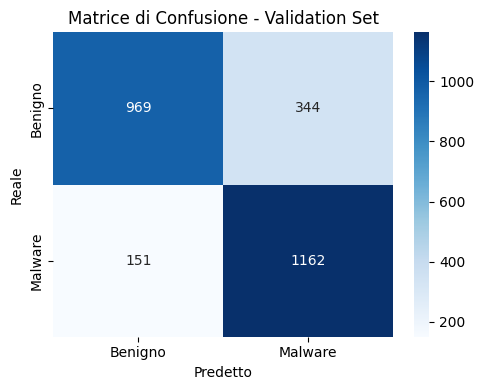


Report di classificazione:

              precision    recall  f1-score   support

     Benigno       0.87      0.74      0.80      1313
     Malware       0.77      0.88      0.82      1313

    accuracy                           0.81      2626
   macro avg       0.82      0.81      0.81      2626
weighted avg       0.82      0.81      0.81      2626



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Valuta il modello
loss, accuracy, y_true, y_pred = get_accuracy(model, val_loader, device, criterion, multiclass=False)
print("Test loss: ", loss)
print("Test accuracy: ", accuracy)

# Assicurati che siano numpy array sulla CPU
if hasattr(y_true, 'cpu'):
    y_true = y_true.cpu().numpy()
if hasattr(y_pred, 'cpu'):
    y_pred = y_pred.cpu().numpy()
# Calcolo metriche
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

# Matrice di confusione
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno', 'Malware'],
            yticklabels=['Benigno', 'Malware'])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione - Validation Set")
plt.tight_layout()
plt.show()

print("\nReport di classificazione:\n")
print(classification_report(y_true, y_pred, target_names=['Benigno', 'Malware']))

Test loss:  tensor(0.0182, device='cuda:0')
Test accuracy:  81.02134146341464
Precision:  0.7612323491655969
Recall:  0.9039634146341463
F1-score:  0.8264808362369338


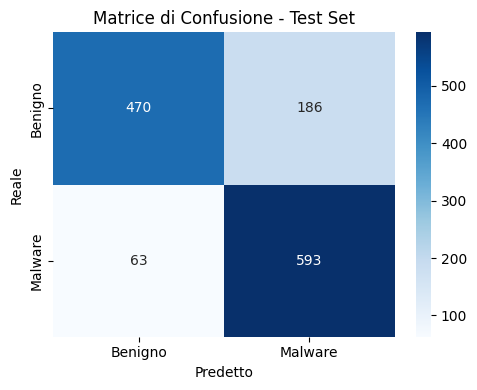


Report di classificazione:

              precision    recall  f1-score   support

     Benigno       0.88      0.72      0.79       656
     Malware       0.76      0.90      0.83       656

    accuracy                           0.81      1312
   macro avg       0.82      0.81      0.81      1312
weighted avg       0.82      0.81      0.81      1312



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Valuta il modello
loss, accuracy, y_true, y_pred = get_accuracy(model, test_loader, device, criterion, multiclass=False)
print("Test loss: ", loss)
print("Test accuracy: ", accuracy)

# Assicurati che siano numpy array sulla CPU
if hasattr(y_true, 'cpu'):
    y_true = y_true.cpu().numpy()
if hasattr(y_pred, 'cpu'):
    y_pred = y_pred.cpu().numpy()
# Calcolo metriche
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

# Matrice di confusione
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno', 'Malware'],
            yticklabels=['Benigno', 'Malware'])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione - Test Set")
plt.tight_layout()
plt.show()

print("\nReport di classificazione:\n")
print(classification_report(y_true, y_pred, target_names=['Benigno', 'Malware']))


Test loss:  tensor(0.0306, device='cuda:0')
Test accuracy:  66.9
Precision:  0.6825053995680346
Recall:  0.632
F1-score:  0.656282450674974


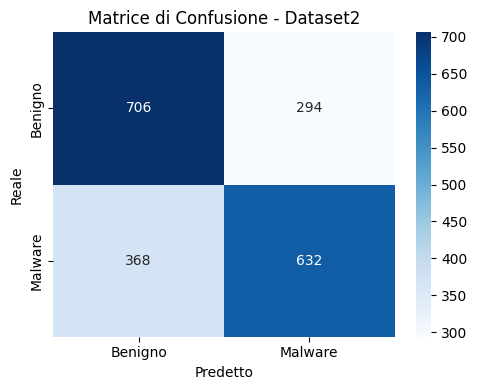


Report di classificazione:

              precision    recall  f1-score   support

     Benigno       0.66      0.71      0.68      1000
     Malware       0.68      0.63      0.66      1000

    accuracy                           0.67      2000
   macro avg       0.67      0.67      0.67      2000
weighted avg       0.67      0.67      0.67      2000



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import torch

# Valuta il modello
loss, accuracy, y_true, y_pred = get_accuracy(model, dataset2_loader, device, criterion, multiclass = False)
print("Test loss: ", loss)
print("Test accuracy: ", accuracy)
precision = precision_score(y_true.cpu(), y_pred.cpu())
recall = recall_score(y_true.cpu(), y_pred.cpu())
f1 = f1_score(y_true.cpu(), y_pred.cpu())

# Assicurati che siano numpy array sulla CPU
if hasattr(y_true, 'cpu'):
    y_true = y_true.cpu().numpy()
if hasattr(y_pred, 'cpu'):
    y_pred = y_pred.cpu().numpy()

    # Calcolo metriche
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1)

# Matrice di confusione
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benigno', 'Malware'],
            yticklabels=['Benigno', 'Malware'])
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.title("Matrice di Confusione - Dataset2")
plt.tight_layout()
plt.show()

# Report completo
print("\nReport di classificazione:\n")
print(classification_report(y_true, y_pred, target_names=['Benigno', 'Malware']))
